In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
def compute_and_save_jeans_deviation(base_dir, suite_name, output_dir):
    """
    Compute the Jeans equation deviation δ_J(r) for each halo and save to CSV.
    """
    density_dir = os.path.join(output_dir, "output", suite_name, "density_profiles")
    velocity_dir = os.path.join(output_dir, "output", suite_name, "velocity_profiles")
    mass_dir = os.path.join(output_dir, "output", suite_name, "mass_profiles")
    out_dir = os.path.join(output_dir, "output", suite_name, "jeans_deviation")
    os.makedirs(out_dir, exist_ok=True)

    halo_files = sorted([f for f in os.listdir(density_dir) if f.endswith(".csv")])

    for f in halo_files:
        halo_id = f.split("_")[1]
        try:
            df_rho = pd.read_csv(os.path.join(density_dir, f))
            df_vel = pd.read_csv(os.path.join(velocity_dir, f))
            df_mass = pd.read_csv(os.path.join(mass_dir, f))

            r = df_rho["r_scaled"].values
            rho = df_rho["rho_scaled"].values
            sigma_r2 = df_vel["sigma_rad_scaled"].values ** 2
            beta = df_vel["beta"].values
            m = df_mass["m_scaled"].values

            # Compute pressure gradient d/dr (rho * sigma_r^2)
            P_r = rho * sigma_r2
            dPdr = np.gradient(P_r, r)

            # Compute dPhi/dr = G * M(<r) / r^2
            dPhidr = m / (r ** 2)

            # Compute numerator and denominator
            numer = dPdr + 2 * beta * P_r / r + rho * dPhidr
            denom = rho * dPhidr

            delta_J = np.abs(numer / denom)

            df_out = pd.DataFrame({
                "halo_id": int(halo_id),
                "r_scaled": r,
                "delta_J": delta_J
            })
            df_out.to_csv(os.path.join(out_dir, f"halo_{int(halo_id):03d}_profile.csv"), index=False)
            print(f"[Saved] Jeans deviation for halo {halo_id}")
        except Exception as e:
            print(f"[Warning] Failed to compute Jeans deviation for halo {halo_id}: {e}")

output_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"


In [18]:
import os
import pandas as pd
import numpy as np

def compute_delta_J_tot(r, delta_J):
    mask = r <= 1.0
    r_cut = r[mask]
    delta_J_cut = delta_J[mask]
    delta_J_tot = np.trapezoid(delta_J_cut, r_cut)
    return delta_J_tot

def compute_and_save_delta_J_tot_per_suite(base_dir, suite_names, jeans_dir_name="jeans_deviation"):
    for suite in suite_names:
        results = []
        jeans_dir = os.path.join(base_dir, "output", suite, jeans_dir_name)
        files = sorted([f for f in os.listdir(jeans_dir) if f.endswith(".csv")])

        for f in files:
            halo_id = int(f.split("_")[1])
            df = pd.read_csv(os.path.join(jeans_dir, f))
            r = df["r_scaled"].values
            delta_J = df["delta_J"].values

            delta_J_tot = compute_delta_J_tot(r, delta_J)

            results.append({
                "halo_id": halo_id,
                "delta_J_tot": delta_J_tot
            })

        df_summary = pd.DataFrame(results)

        output_csv = os.path.join(base_dir, "output", suite, f"jeans_deviation_total.csv")
        df_summary.to_csv(output_csv, index=False)
        print(f"[Saved] Jeans deviation total summary for {suite} to {output_csv}")

base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"]

compute_and_save_delta_J_tot_per_suite(base_dir, suite_names)

[Saved] Jeans deviation total summary for SymphonyLMC to /Users/fengbocheng/Projects/Symphony-PPSD/output/SymphonyLMC/jeans_deviation_total.csv
[Saved] Jeans deviation total summary for SymphonyMilkyWay to /Users/fengbocheng/Projects/Symphony-PPSD/output/SymphonyMilkyWay/jeans_deviation_total.csv
[Saved] Jeans deviation total summary for SymphonyGroup to /Users/fengbocheng/Projects/Symphony-PPSD/output/SymphonyGroup/jeans_deviation_total.csv
[Saved] Jeans deviation total summary for SymphonyLCluster to /Users/fengbocheng/Projects/Symphony-PPSD/output/SymphonyLCluster/jeans_deviation_total.csv


Spearman ρ = -0.221, p = 4.57e-03


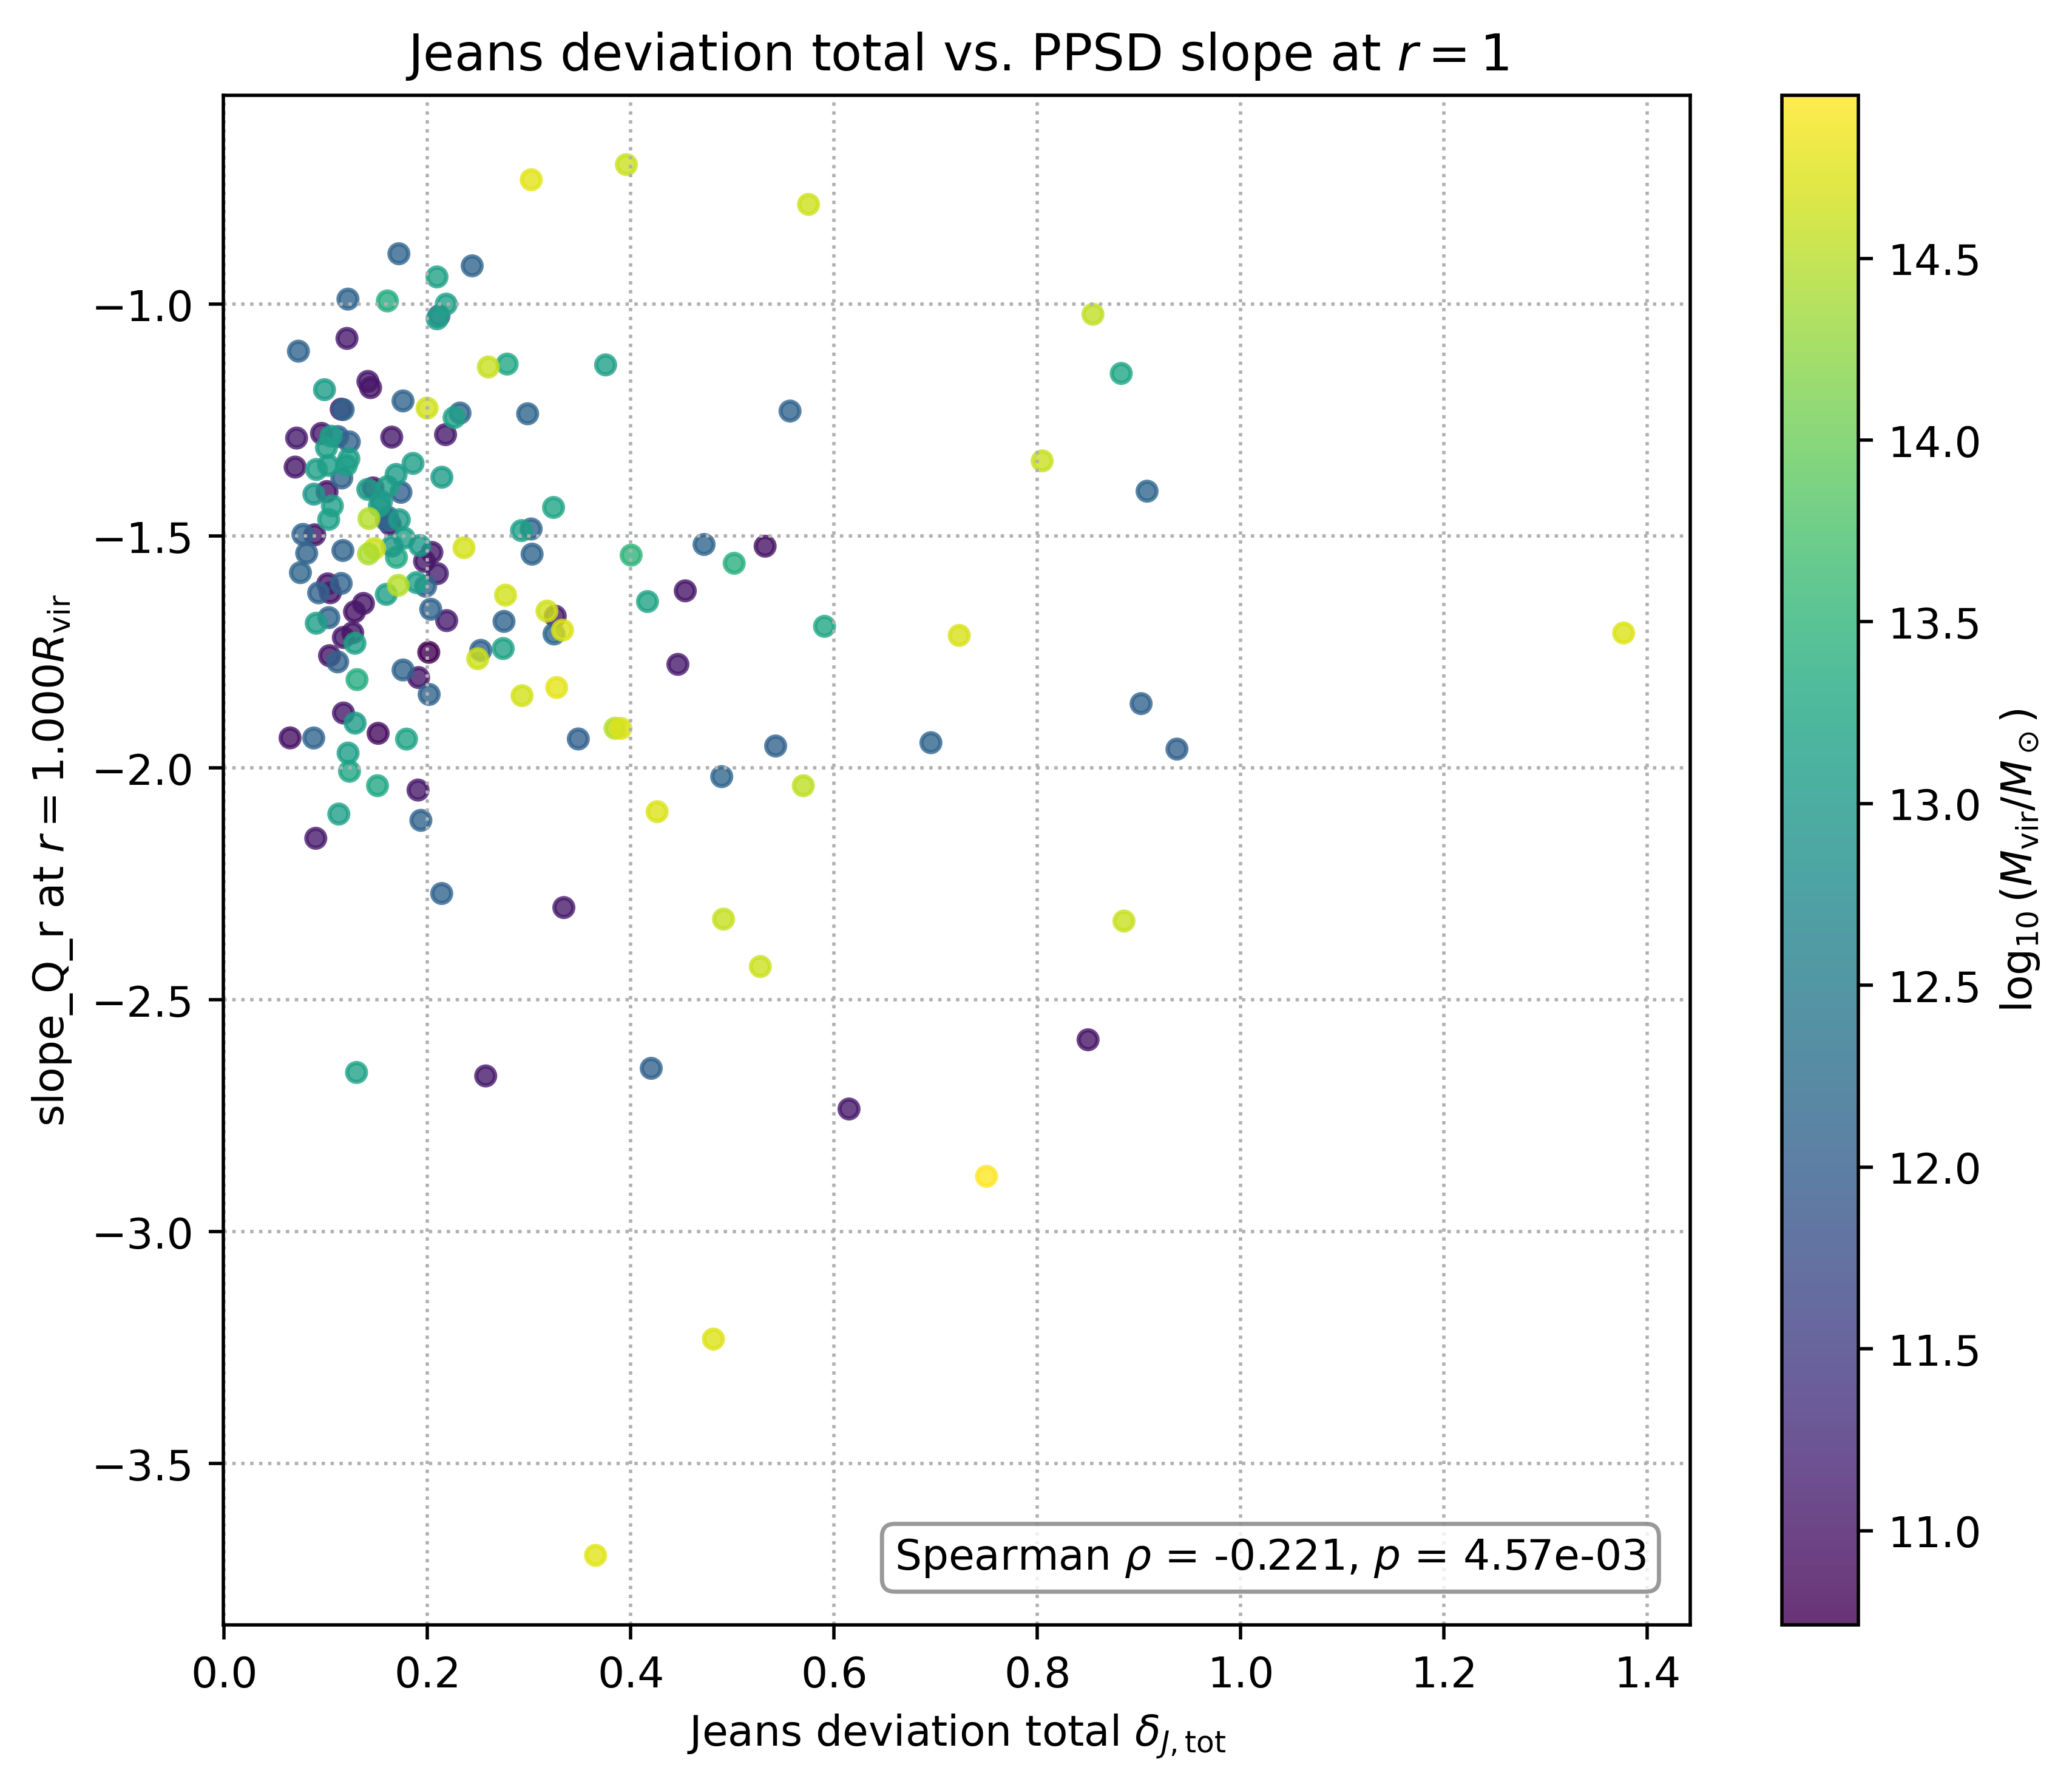

In [28]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.stats import spearmanr

def quantify_slope_jeans_total_relation(base_dir, suite_names, r_target=0.01, slope_var="slope_Q_r"):
    slope_vals, jeans_tot_vals, mass_vals = [], [], []

    for suite in suite_names:
        slope_dir = os.path.join(base_dir, "output", suite, "ppsd_slope_profiles_r")
        jeans_tot_path = os.path.join(base_dir, "output", suite, "jeans_deviation_total.csv")
        mass_path = os.path.join(base_dir, "output", suite, "halo_mass.csv")

        # 读取 Jeans deviation total 和 halo mass 的数据
        df_jeans_tot = pd.read_csv(jeans_tot_path)
        df_mass = pd.read_csv(mass_path)
        mass_dict = dict(zip(df_mass["halo_id"], df_mass["mvir"]))
        jeans_tot_dict = dict(zip(df_jeans_tot["halo_id"], df_jeans_tot["delta_J_tot"]))

        for f in sorted([f for f in os.listdir(slope_dir) if f.endswith(".csv")]):
            try:
                halo_id = int(f.split("_")[1])
                slope_df = pd.read_csv(os.path.join(slope_dir, f))

                r_slope = slope_df["r_scaled"].values
                slope = slope_df[slope_var].values

                # 插值取 r_target 处的 slope
                interp_slope = interp1d(r_slope, slope, bounds_error=False, fill_value=np.nan)
                slope_val = float(interp_slope(r_target))

                jeans_val = jeans_tot_dict.get(halo_id, np.nan)
                mass = mass_dict.get(halo_id, np.nan)

                if np.isfinite(slope_val) and np.isfinite(jeans_val):
                    slope_vals.append(slope_val)
                    jeans_tot_vals.append(jeans_val)
                    mass_vals.append(mass)
            except Exception as e:
                print(f"[Warning] Failed to process halo {f} in {suite}: {e}")

    slope_vals = np.array(slope_vals)
    jeans_tot_vals = np.array(jeans_tot_vals)
    log_mass = np.log10(np.array(mass_vals))

    if len(slope_vals) < 2:
        print("[Warning] Not enough data.")
        return

    # 计算 Spearman 相关系数
    spearman_r, spearman_p = spearmanr(jeans_tot_vals, slope_vals)

    # 绘图
    plt.figure(figsize=(7, 6), dpi=500)
    scatter = plt.scatter(jeans_tot_vals, slope_vals, c=log_mass, cmap="viridis", s=20, alpha=0.8)
    cbar = plt.colorbar(scatter, label=r"$\log_{10}(M_{\rm vir} / M_\odot)$")
    plt.xlabel(r"Jeans deviation total $\delta_{J, \mathrm{tot}}$")
    plt.ylabel(fr"{slope_var} at $r = {r_target:.3f} R_{{\rm vir}}$")
    plt.title(f"Jeans deviation total vs. PPSD slope at $r = {r_target}$")
    plt.grid(True, linestyle=":")
    plt.tight_layout()

    # 相关性注释
    textstr = '\n'.join((
        rf"Spearman $\rho$ = {spearman_r:.3f}, $p$ = {spearman_p:.2e}",
    ))
    plt.text(0.97, 0.03, textstr, transform=plt.gca().transAxes,
             fontsize=10, va='bottom', ha='right',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8))

    print(f"Spearman ρ = {spearman_r:.3f}, p = {spearman_p:.2e}")
    plt.show()

# 使用示例
base_dir = "/Users/fengbocheng/Projects/Symphony-PPSD"
suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster"]

quantify_slope_jeans_total_relation(
    base_dir, suite_names,
    r_target=1,
    slope_var="slope_Q_r"
)